 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bytes_in             282 non-null    int64 
 1   bytes_out            282 non-null    int64 
 2   creation_time        282 non-null    object
 3   end_time             282 non-null    object
 4   src_ip               282 non-null    object
 5   src_ip_country_code  282 non-null    object
 6   protocol             282 non-null    object
 7   response.code        282 non-null    int64 
 8   dst_port             282 non-null    int64 
 9   dst_ip               282 non-null    object
 10  rule_names           282 non-null    object
 11  observation_name     282 non-null    object
 12  source.meta          282 non-null    object
 13  source.name          282 non-null    object
 14  time                 282 non-null    object
 15  detection_types      282 non-null    objec

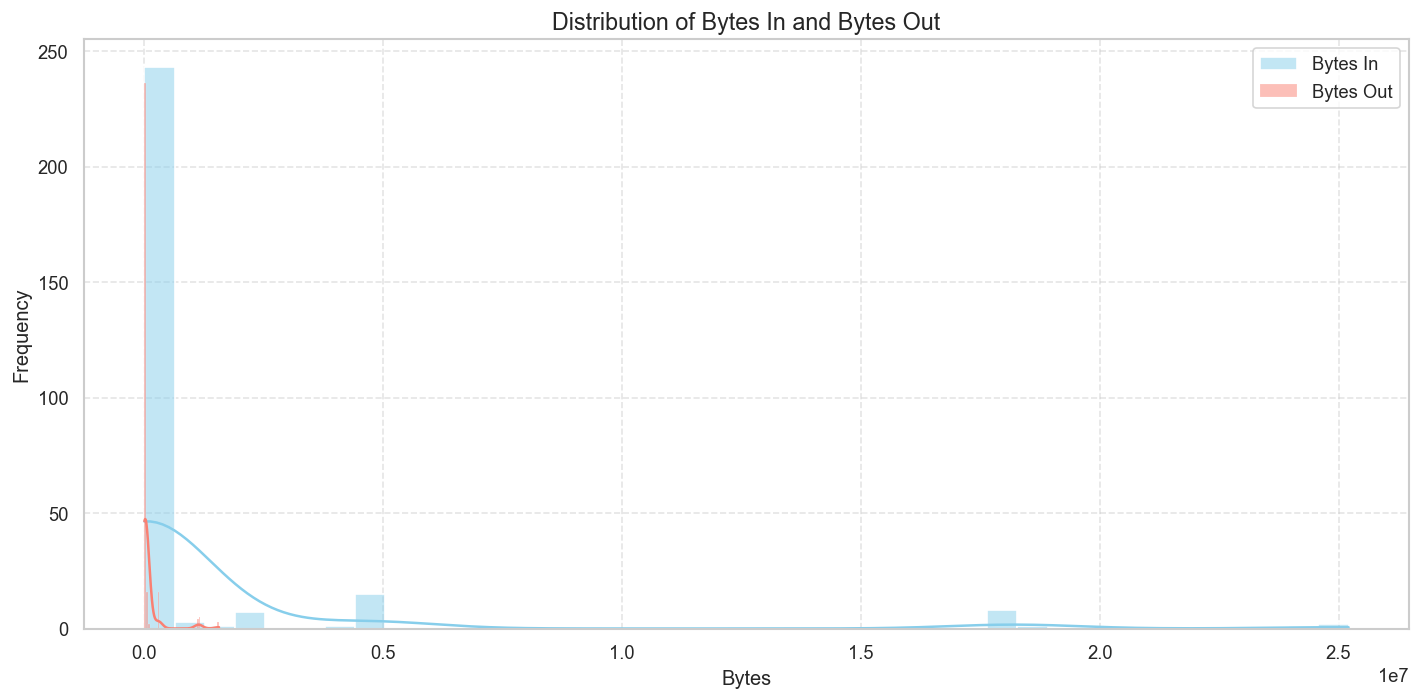

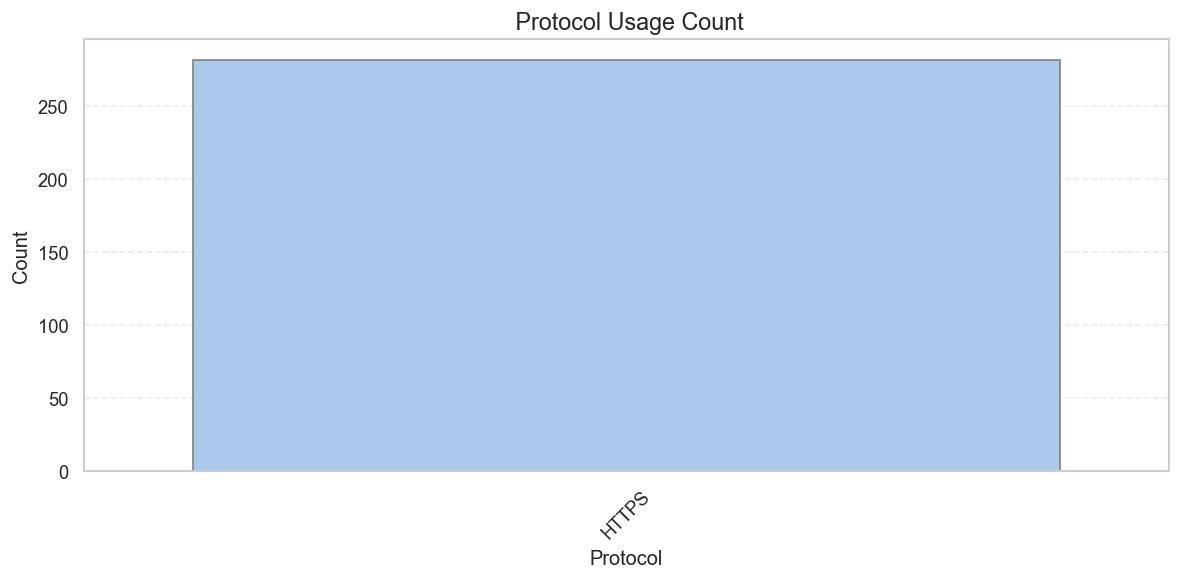

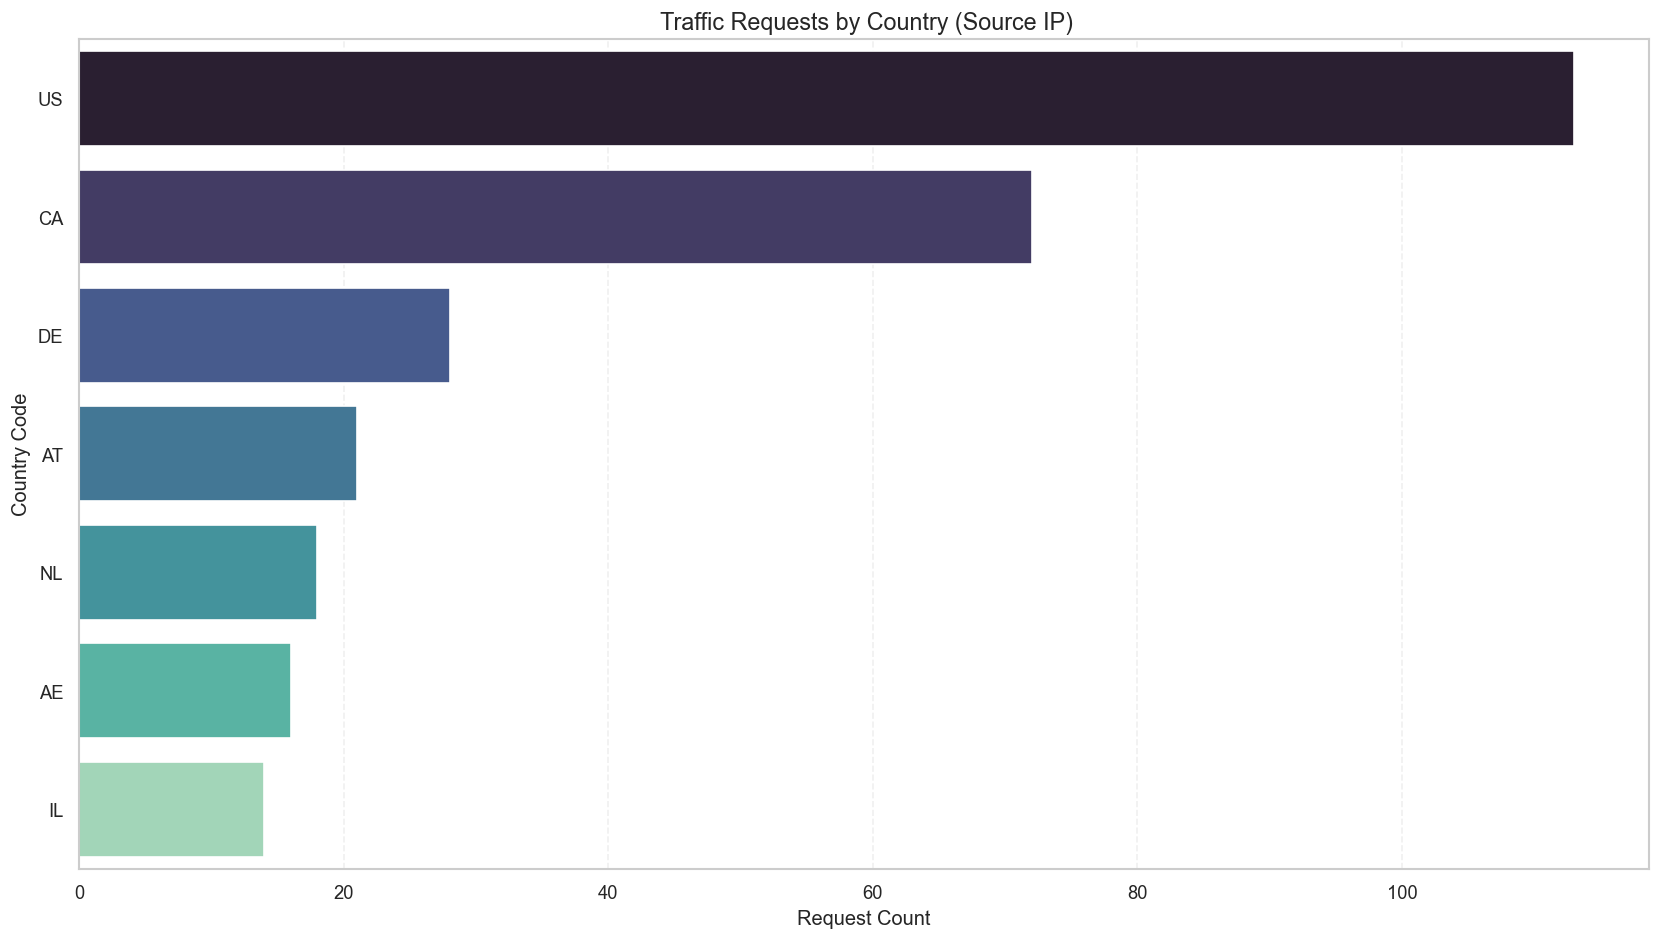

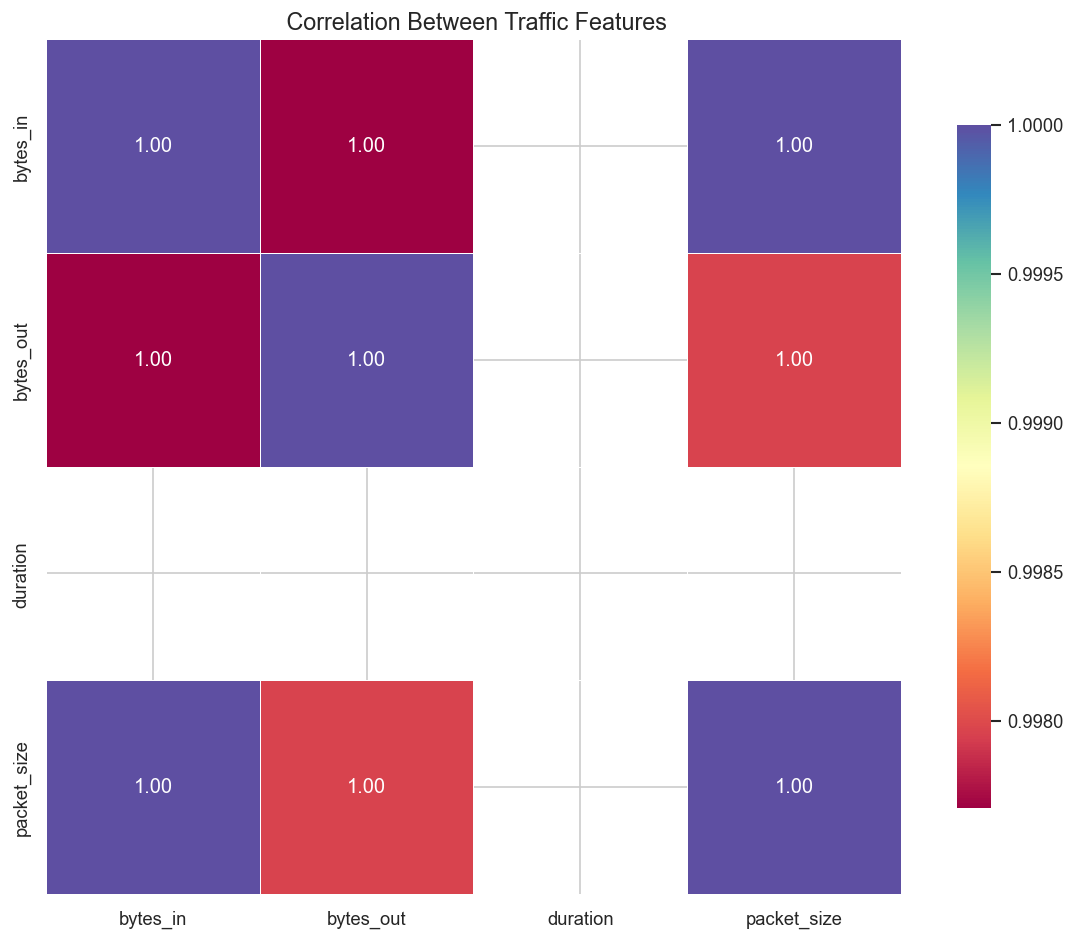

 Anomaly Detection Results:
anomaly
Normal        267
Suspicious     15
Name: count, dtype: int64
 Suspicious vs Normal (Label Counts):
is_suspicious
1    282
Name: count, dtype: int64
 Random Forest Accuracy: 1.0

 Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        85

    accuracy                           1.00        85
   macro avg       1.00      1.00      1.00        85
weighted avg       1.00      1.00      1.00        85

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8760 - loss: 0.6997 - val_accuracy: 0.9000 - val_loss: 0.6793
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9595 - loss: 0.6712 - val_accuracy: 1.0000 - val_loss: 0.6515
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9696 - loss: 0.6462 - val_accuracy: 1.0000 - val_loss: 0.6159
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9606 - loss: 0.6059 - val_accuracy: 1.0000 -

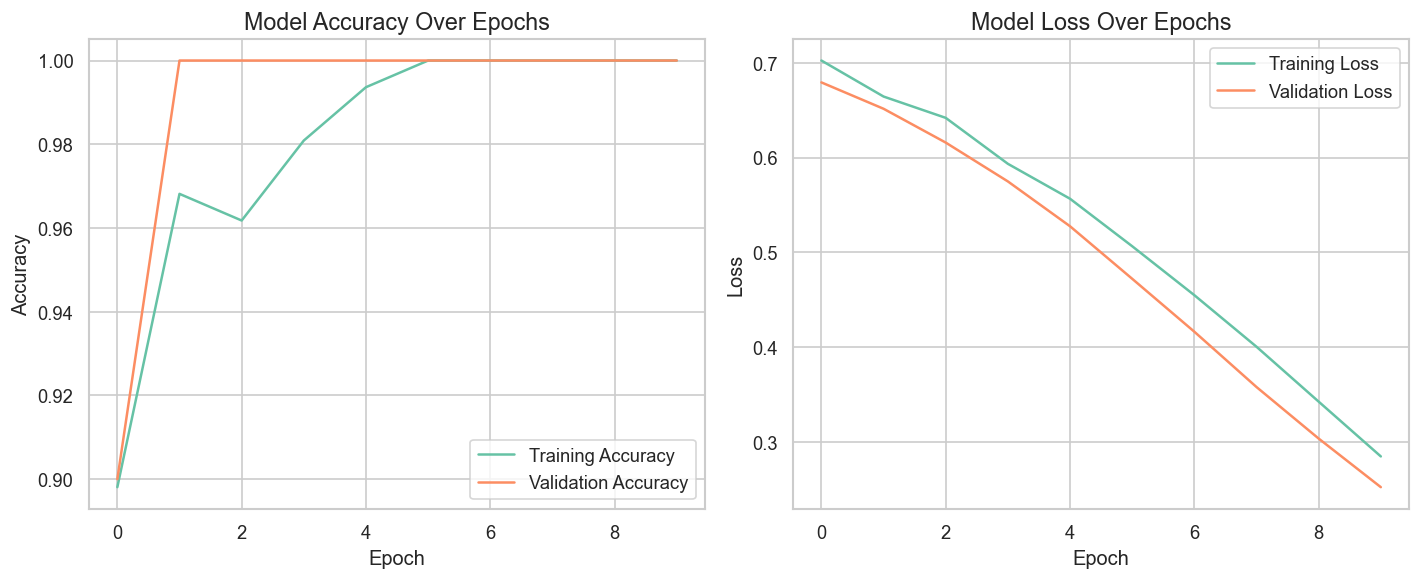


 Total Suspicious Predictions (Random Forest):
282 rows classified as suspicious

 Anomaly Detection Summary:
anomaly
Normal        267
Suspicious     15
Name: count, dtype: int64

 Example of Detected Suspicious Traffic:
     bytes_in  bytes_out             creation_time                  end_time  \
36    4190330     283456 2024-04-25 23:30:00+00:00 2024-04-25 23:40:00+00:00   
87    1215594      64362 2024-04-26 00:30:00+00:00 2024-04-26 00:40:00+00:00   
116   4827283     306181 2024-04-26 01:00:00+00:00 2024-04-26 01:10:00+00:00   
132   1889834      34306 2024-04-26 01:20:00+00:00 2024-04-26 01:30:00+00:00   
153   4869181     301752 2024-04-26 01:40:00+00:00 2024-04-26 01:50:00+00:00   

             src_ip src_ip_country_code protocol  response.code  dst_port  \
36    155.91.45.242                  US    HTTPS            200       443   
87   165.225.240.79                  NL    HTTPS            200       443   
116   155.91.45.242                  US    HTTPS            200  

In [3]:

# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# it Set better visual theme using matplotlib and seaborn
sns.set_theme(style='whitegrid', palette='Set2')
plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# now we will load the dataset using panda 
df = pd.read_csv("CloudWatch_Traffic_Web_Attack.csv")
print(" Dataset Info:")
df.info()
print("\n First 5 Rows:")
print(df.head())

#  here were doing Data Cleaning
df.drop_duplicates(inplace=True)
df['creation_time'] = pd.to_datetime(df['creation_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df['time'] = pd.to_datetime(df['time'])
df['src_ip_country_code'] = df['src_ip_country_code'].str.upper()
print("\n Data cleaned.")
df.info()

# blacklist flag
"""
I personally added a custom security feature to improve the model's ability to detect threats.
This includes creating a small list of known dangerous IP addresses (called a blacklist).
If a source IP matches one in this list, it's flagged as 1 (suspicious) in a new column 'is_blacklisted'.
This helps the ML models treat traffic from known malicious IPs as more dangerous.
"""
blacklist = [
    '203.0.113.10',
    '198.51.100.5',
    '192.168.1.99',
    '45.83.64.1',
    '172.16.254.1'
]
df['is_blacklisted'] = df['src_ip'].isin(blacklist).astype(int)
print("\n Blacklisted IPs Found:")
print(df['is_blacklisted'].value_counts())


#  feature 
df['duration'] = (df['end_time'] - df['creation_time']).dt.total_seconds()
df['packet_size'] = (df['bytes_in'] + df['bytes_out']) / df['duration']
print("\n Features added: 'duration' & 'packet_size'")
print(df[['bytes_in', 'bytes_out', 'duration', 'packet_size']].head())



plt.figure(figsize=(12, 6))
sns.histplot(df['bytes_in'], bins=40, color='skyblue', label='Bytes In', kde=True)
sns.histplot(df['bytes_out'], bins=40, color='salmon', label='Bytes Out', kde=True)
plt.title( "Distribution of Bytes In and Bytes Out")
plt.xlabel("Bytes")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(x='protocol', data=df, palette='pastel', edgecolor='gray')
plt.title(" Protocol Usage Count")
plt.xlabel("Protocol")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 8))
sns.countplot(
    y='src_ip_country_code',
    data=df,
    order=df['src_ip_country_code'].value_counts().index,
    palette='mako'
)
plt.title(" Traffic Requests by Country (Source IP)")
plt.xlabel("Request Count")
plt.ylabel("Country Code")
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(
    df[['bytes_in', 'bytes_out', 'duration', 'packet_size']].corr(),
    annot=True,
    cmap='Spectral',
    fmt=".2f",
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.title(" Correlation Between Traffic Features")
plt.tight_layout()
plt.show()

# anomaly detection
features = df[['bytes_in', 'bytes_out', 'duration', 'packet_size']]
model = IsolationForest(contamination=0.05, random_state=42)
df['anomaly'] = model.fit_predict(features)
df['anomaly'] = df['anomaly'].map({-1: 'Suspicious', 1: 'Normal'})
print(" Anomaly Detection Results:")
print(df['anomaly'].value_counts())



df['is_suspicious'] = (df['detection_types'] == 'waf_rule').astype(int)
print(" Suspicious vs Normal (Label Counts):")
print(df['is_suspicious'].value_counts())

X = df[['bytes_in', 'bytes_out', 'duration', 'packet_size', 'is_blacklisted']]
y = df['is_suspicious']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print(" Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

#neural Network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=8, validation_split=0.2, verbose=1)


loss, accuracy = model.evaluate(X_test, y_test)

print(f"\n Neural Network Test Accuracy: {accuracy*100:.2f}%")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()




print("\n Total Suspicious Predictions (Random Forest):")
print(df[df['is_suspicious'] == 1].shape[0], "rows classified as suspicious")

print("\n Anomaly Detection Summary:")
print(df['anomaly'].value_counts())

print("\n Example of Detected Suspicious Traffic:")
print(df[df['anomaly'] == 'Suspicious'].head())
